In [1]:
import pandas as pd
import numpy as np

## <font color=black>Leitura de Dados</font> 

In [2]:
# Read all files 
country = pd.read_csv('Country_Original.csv')
league = pd.read_csv('League_Original.csv')
match = pd.read_csv('Match_Original.csv')
player = pd.read_csv('Player_Original.csv')
player_attributes = pd.read_csv('Player_Attributes_Original.csv')
team = pd.read_csv('Team_Original.csv')
team_attributes = pd.read_csv('Team_Attributes_Original.csv')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## <font color=black>Organização e Limpeza de Dados</font> 

Pretendemos nesta secção do trabalho reduzir e tratar os dados de forma a que não exista informação irrelevante para o modelo que pretendemos construir.

### <font color=black> - Eliminação de Valores Nulos</font>

In [3]:
# Eliminar atributos relativos à posição dos jogadores
player_attributes.drop(player_attributes.columns.to_series()["potential":], axis=1, inplace = True)


In [4]:
# Eliminar duplicados caso existam
player_attributes.drop_duplicates(keep = False, inplace = True)

In [5]:
# Verficar se existe overall_ratings null
player_attributes.dropna(axis=0, how="any", subset =['overall_rating'], inplace=True)
player_attributes['overall_rating'].isnull().sum()

0

In [6]:
# Eliminar atributos relativos à posição dos jogadores
match.drop(match.columns.to_series()["home_player_X1":"away_player_Y11"], axis=1, inplace = True)
# Eliminar os seguintes atributos -> shoton, shotoff, foulcommit, card, cross, corner, possession
match.drop(match.columns.to_series()["goal":"possession"], axis=1,inplace = True)

In [7]:
#Organizar dados por datas, do passado para o presente
match['date'] = match['date'].astype('datetime64[ns]')
match = match.sort_values(by=['date'], ascending=True)

In [8]:
#Eliminar todos as linhas que não tenham nenhuma info sobre os jogadores
match = match.dropna(axis=0, how="all", subset=match.columns.to_series()["home_player_1":"away_player_11"])

In [9]:
#Eliminar todas as linhas que não tenham nenhuma odd relativa ao jogo
match.dropna(axis=0, how="all", subset=match.columns.to_series()["B365H":], inplace=True)

In [10]:
#Eliminar partidas em que não são conhecidos pelo menos 8 jogadores que jogaram (para a Equipa da Casa)
match = match.dropna(axis=0, thresh=8, subset=match.columns.to_series()["home_player_1":"home_player_11"])
#Verificação
match.loc[match.loc[:,'home_player_1':'home_player_11'].count(axis=1) < 8]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA


In [11]:
#Eliminar partidas em que não são conhecidos pelo menos 8 jogadores que jogaram (para a Equipa de Fora)
match = match.dropna(axis=0, thresh=8, subset=match.columns.to_series()["away_player_1":"away_player_11"])
#Verificação
match.loc[match.loc[:,'away_player_1':'away_player_11'].count(axis=1) < 8]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA


### <font color=black> - Substituição de Valores Nulos </font>

In [12]:
#Passar o formato dos atributos 'date' para formato de tempo
match['date'] = match['date'].astype('datetime64[ns]') 
player_attributes['date'] = player_attributes['date'].astype('datetime64[ns]') 
team_attributes['date'] = team_attributes['date'].astype('datetime64[ns]') 

In [13]:
#Create copy of the match and player dataframe
match_copy = match.copy()
player_copy = player.copy()
player_height = player_copy[["player_api_id", "height","weight"]].copy()

In [14]:
# Merge das alturas e pesos para casa jogador em específico - Casa
for i in range(1,12):
    match_copy = match_copy.merge(player_height, how='left', left_on=['home_player_'+'%s'%i], right_on=['player_api_id'], suffixes=('', '_home_'+'%s'%i), validate="m:1") 

In [15]:
# Eliminar as colunas do player_api_id e o mudar o nome de height para height_home_1
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='player_api_id')))]
match_copy.rename(columns={"height": "height_home_1"}, inplace=True)
match_copy.rename(columns={"weight": "weight_home_1"}, inplace=True)

In [16]:
# Fazer média das altura e pesos
match_copy['mean_height_home']= match_copy[list(match_copy.filter(regex='height_home'))].mean(axis=1)
match_copy['mean_weight_home']= match_copy[list(match_copy.filter(regex='weight_home'))].mean(axis=1)

In [17]:
# Merge das alturas e pesos para casa jogador em específico - Fora
for i in range(1,12):
    match_copy = match_copy.merge(player_height, how='left', left_on=['away_player_'+'%s'%i], right_on=['player_api_id'], suffixes=('', '_away_'+'%s'%i), validate="m:1") 

In [18]:
# Eliminar as colunas do player_api_id e o mudar o nome de height para height_away_1
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='player_api_id')))]
match_copy.rename(columns={"height": "height_away_1"}, inplace=True)
match_copy.rename(columns={"weight": "weight_away_1"}, inplace=True)

In [19]:
# Fazer média das altura e pesos
match_copy['mean_height_away']= match_copy[list(match_copy.filter(regex='height_away'))].mean(axis=1)
match_copy['mean_weight_away']= match_copy[list(match_copy.filter(regex='weight_away'))].mean(axis=1)

In [20]:
# Eliminar colunas com alturas e pesos dos jogadores 
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='height_home_')))]
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='height_away_')))]
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='weight_home_')))]
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='weight_away_')))]

In [21]:
#Criar Listas com os labbels das odds para Home, Draw, Away
home_ods = [a for a in match_copy.columns if a.endswith('H')]
draw_ods = [b for b in match_copy.columns if b.endswith('D')]
away_ods = [c for c in match_copy.columns if c.endswith('A')]

In [22]:
# Fazer média das odds
match_copy['mean_ods_home'] = match_copy[home_ods].mean(axis=1)
match_copy['mean_ods_draw'] = match_copy[draw_ods].mean(axis=1)
match_copy['mean_ods_away'] = match_copy[away_ods].mean(axis=1)

In [23]:
#Retirar colunas das ods
odds_indices_drop = ['B365H','B365D','B365A','BWH','BWD','BWA','IWH','IWD','IWA','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','SJH','SJD','SJA','VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD','BSA']
match_copy.drop(columns=odds_indices_drop, inplace=True)

In [24]:
# Ir buscar os overall_ratings para cada jogador a jogar a partida - Casa
player_ratings = player_attributes[["player_api_id", "date","overall_rating"]].copy()
for i in range(1,12):
    match_copy = match_copy.merge(player_ratings, how='outer', left_on=['home_player_'+'%s'%i], right_on=['player_api_id'], suffixes=('', '_home'), validate="m:m")
    index_to_drop1 = match_copy[ (match_copy['date_home'] > match_copy['date'])].index
    match_copy.drop(index_to_drop1 , inplace=True)
    match_copy.drop_duplicates(subset= ['id'], keep='first', inplace=True) 
    match_copy.rename(columns={"overall_rating": "or_home_player_"+'%s'%i}, inplace=True)
    match_copy.drop(columns=['player_api_id','date_home'] , inplace=True)

In [25]:
# Ir buscar os overall_ratings para cada jogador a jogar a partida - Fora
for i in range(1,12):
    match_copy = match_copy.merge(player_ratings, how='outer', left_on=['away_player_'+'%s'%i], right_on=['player_api_id'], suffixes=('', '_away'), validate="m:m")
    index_to_drop1 = match_copy[ (match_copy['date_away'] > match_copy['date'])].index
    match_copy.drop(index_to_drop1 , inplace=True)
    match_copy.drop_duplicates(subset= ['id'], keep='first', inplace=True) 
    match_copy.rename(columns={"overall_rating": "or_away_player_"+'%s'%i}, inplace=True)
    match_copy.drop(columns=['player_api_id','date_away'] , inplace=True)

In [26]:
# Criar média dos Overall Ratings da equipa da casa e fora, assim como eliminar os valores associados aos jogador dado que
# agora só nos interessa a média

match_copy['mean_or_home']= match_copy[list(match_copy.filter(regex='or_home_player'))].mean(axis=1)
match_copy['mean_or_away']= match_copy[list(match_copy.filter(regex='or_away_player'))].mean(axis=1)
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='or_away_player_')))]
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='or_home_player_')))]
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='home_player')))]
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='away_player')))]

In [27]:
#Eliminar valores adicionados ao match devido ao outter join e que não fazem sentido
match_copy = match_copy.dropna(axis=0, subset=['id'])

In [28]:
# Cálculo da diferença de golos 
match_copy["dif_goals"] = match_copy.home_team_goal - match_copy.away_team_goal
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='home_team_goal')))]
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='away_team_goal')))]


In [29]:
match_copy = match_copy[match_copy.columns.drop(list(match_copy.filter(regex='country_id')))]

In [30]:
team_attributes_copy = team_attributes.copy()

In [31]:
colToDrop = [d for d in team_attributes_copy.columns if d.endswith('Class')]
team_attributes_copy.drop(columns=colToDrop, inplace=True)

In [32]:
# Verificação de que existem pelo menos dois parametros para avaliar a equipa
team_attributes_copy = team_attributes_copy.dropna(axis=0, thresh=2, subset=["buildUpPlaySpeed", "buildUpPlayDribbling" ,"buildUpPlayPassing"])
team_attributes_copy = team_attributes_copy.dropna(axis=0, thresh=2, subset=["chanceCreationPassing","chanceCreationCrossing","chanceCreationShooting"])
team_attributes_copy = team_attributes_copy.dropna(axis=0, thresh=2, subset=["defencePressure","defenceAggression","defenceTeamWidth"])

In [33]:
#Divide os atributos das equipas em 3 categorias : Atacante, medio e defesa
team_attributes_copy["offense_team_rates"] = team_attributes_copy[list(team_attributes_copy.filter(regex='buildUp'))].mean(axis=1)
team_attributes_copy["center_team_rates"] = team_attributes_copy[list(team_attributes_copy.filter(regex='chanceCreation'))].mean(axis=1)
team_attributes_copy["defense_team_rates"] = team_attributes_copy[list(team_attributes_copy.filter(regex='defence'))].mean(axis=1)

In [34]:
#Elimina as colunas que não vão ser utilizadas. Uma vez que as colunas novas já se encontram na tabela
team_attributes_copy = team_attributes_copy[team_attributes_copy.columns.drop(list(team_attributes_copy.filter(regex='buildUp')))]
team_attributes_copy = team_attributes_copy[team_attributes_copy.columns.drop(list(team_attributes_copy.filter(regex='chanceCreation')))]
team_attributes_copy = team_attributes_copy[team_attributes_copy.columns.drop(list(team_attributes_copy.filter(regex='defence')))]


In [35]:
#Definir as rates a inserir na tabela principal
team_ratings = team_attributes_copy[["team_api_id" ,  "date", "offense_team_rates" , "center_team_rates", "defense_team_rates"]]

In [36]:
match_copy.isnull().sum()

id                  0
league_id           0
season              0
stage               0
date                0
match_api_id        0
home_team_api_id    0
away_team_api_id    0
mean_height_home    0
mean_weight_home    0
mean_height_away    0
mean_weight_away    0
mean_ods_home       0
mean_ods_draw       0
mean_ods_away       0
mean_or_home        0
mean_or_away        0
dif_goals           0
dtype: int64

In [37]:
#Merge para a tabela principal dos ratings da equipa da casa
match_copy = match_copy.merge(team_ratings, how='outer', left_on=["home_team_api_id"], right_on=['team_api_id'], suffixes=('', '_home'), validate="m:m")

In [38]:
#Tratar o merge da equipa da casa
index_to_drop1 = match_copy[ (match_copy['date_home'] > match_copy['date'])].index
match_copy.drop(index_to_drop1 , inplace=True)
match_copy.drop_duplicates(subset= ['id'], keep='last', inplace=True) 
match_copy.rename(columns={"offense_team_rates": "offense_team_rates_home", "center_team_rates" : "center_team_rates_home", "defense_team_rates":"defense_team_rates_home"}, inplace=True)
match_copy.drop(columns=['date_home', 'team_api_id'] , inplace=True)

In [39]:
#Eliminar valores adicionados ao match devido ao outter join e que não fazem sentido
match_copy = match_copy.dropna(axis=0, subset=['id'])

In [40]:
match_copy = match_copy.merge(team_ratings, how='outer', left_on=["away_team_api_id"], right_on=['team_api_id'], suffixes=('', '_away'), validate="m:m")

In [41]:
#Tratar o merge da equipa de fora
index_to_drop1 = match_copy[ (match_copy['date_away'] > match_copy['date'])].index
match_copy.drop(index_to_drop1 , inplace=True)
match_copy.drop_duplicates(subset= ['id'], keep='last', inplace=True) 
match_copy.rename(columns={"offense_team_rates": "offense_team_rates_away", "center_team_rates" : "center_team_rates_away", "defense_team_rates":"defense_team_rates_away"}, inplace=True)
match_copy.drop(columns=['date_away', 'team_api_id'] , inplace=True)

In [42]:
#Eliminar valores adicionados ao match devido ao outter join e que não fazem sentido
match_copy = match_copy.dropna(axis=0, subset=['id'])

In [43]:
#match_copy.isnull().sum()
# Se descomentarmos o comando em cima podemos ver que existem dados relativos às equipas. Isto deve-se ao facto de o 
# id destas não estar presenta na base de dados dos Team Attributes. Sendo assim podemos eliminar os valores nulos
match_copy.dropna(inplace=True)

In [44]:
match_copy.shape

(16918, 24)

In [45]:
match_copy = match_copy.round(2)

In [46]:
match_copy.to_csv('pre_processed_df', index=False)

## <font color=black>Modelos de Aprendizagem (Regressão)</font> 

Após o tratamento e pré-processamento de dados, é possivel aplicar os algoritmos de aprendizagem supervisionada sobre os mesmos com o objetivo final de prever a diferença de golos entre duas equipas a jogar uma partida. <br>
Como algoritmos de aprendizagem escolhemos utilizar:
    - Àrvores de decisão
    - Redes Neuronais
    - Máquinas de Suporte Vetorial


Inicialmente é necessário importar um conjunto de bibliotecas que permitem e facilitam o uso destes modelos e fazer a leitura do ficheiro construído no pré-processamento.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, max_error, mean_squared_error, r2_score, mean_absolute_error

In [5]:
# ler ficheiro pré-processado 
df = pd.read_csv('pre_processed_df')

Após a leitura do ficheiro é necessário dividir os atributos de entrada e saída. Neste caso possuímos um atributo de saída (diferença de golos, valor a prever), portanto, atribuimos esse mesmo a 'y' e os restantes a 'X'.

In [6]:
#Divisão entre entradas e saída

X = df.drop(['id', 'league_id', 'season', 'stage', 'date','dif_goals'],axis=1)

y = df['dif_goals']

Tendo os dados divididos em entradas e saídas, o próximo passo trata a divisão dos dados num conjunto para treino e num conjunto para teste. Esta divisão é facilitada pela função de 'train_test_split()' disponibilizada pela biblioteca 'scikit-learn'.<br>
<br>O conjunto de treino é responsável pela construção do modelo de aprendizagem. É através deste que o modelo que, iterativamente, são ajustados os seus parâmetros de forma a otimizar o resultado produzido.<br>
O conjunto de teste tem a função de, como o nome indica, avaliar o desempenho do modelo produzido pelo conjunto de treino e verificar se os resultados produzidos coincidem com o resultado verdadeiro. <br>
<br>Dada a importância do treino, optamos por utilizar 85% para o mesmo e os restantes 15% para teste.<br>

<br>É importante ter em conta que os dados apresentam grandezas e escalas diferentes sendo importante a sua normalização de forma a garantir integridade dos mesmos.


In [7]:
# Dividir dados em sets de Treino e Teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15)

# Normalização de Dados
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### <font color=black> - Árvore de Decisão </font> 

In [ ]:
# Treinar o modelo - Árvores de Decisão
tick = time()

rfr = RandomForestRegressor(n_estimators=350)
rfr.fit(X_train, y_train)
prediction_rfr = rfr.predict(X_test)

print("Done in {:.3f}s".format(time() - tick))

In [ ]:
# Imprimir métricas para avaliação do desempenho do modelo

print("Explained Variance Score:",explained_variance_score(y_test, prediction_rfr))
print("Max Error:",max_error(y_test, prediction_rfr))
print("R2 Score:",r2_score(y_test, prediction_rfr))
print("Mean Square Error:",mean_squared_error(y_test, prediction_rfr))
print("Mean Absolute Error:",mean_absolute_error(y_test, prediction_rfr))

### <font color=black> - Rede Neuronal </font> 

In [18]:
# Treinar o modelo - Rede Neuronal
tick = time()

mlp = make_pipeline(QuantileTransformer(), MLPRegressor(hidden_layer_sizes=(50,50),learning_rate_init=0.01,early_stopping=True))
mlp.fit(X_train, y_train)
prediction_mlp = mlp.predict(X_test)

print("Done in {:.3f}s".format(time() - tick))

Done in 4.980s


In [19]:
# Imprimir métricas para avaliação do desempenho do modelo

print("Explained Variance Score:",explained_variance_score(y_test, prediction_mlp))
print("Max Error:",max_error(y_test, prediction_mlp))
print("R2 Score:",r2_score(y_test, prediction_mlp))
print("Mean Square Error:",mean_squared_error(y_test, prediction_mlp))
print("Mean Absolute Error:",mean_absolute_error(y_test, prediction_mlp))

Explained Variance Score: 0.2227818455594749
Max Error: 7.372272196547768
R2 Score: 0.22278179779742802
Mean Square Error: 2.465646427936281
Mean Absolute Error: 1.225818165769713


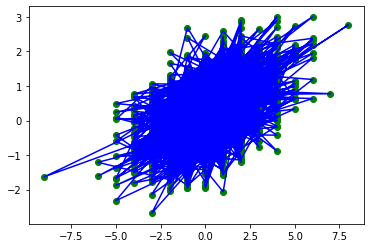

In [22]:
plt.scatter(y_test, prediction_mlp,color='g')
plt.plot(y_test, prediction_mlp,color='b')
plt.show()

### <font color=black> - Máquina de Suporte Vetorial </font> 

In [ ]:
# Treinar o modelo - SVR
tick = time()

svr= SVR()
svr.fit(X_train, y_train)
prediction_svr = svr.predict(X_test)

print("Done in {:.3f}s".format(time() - tick))

In [ ]:
print("Explained Variance Score:",explained_variance_score(y_test, prediction_svr))
print("Max Error:",max_error(y_test, prediction_svr))
print("R2 Score:",r2_score(y_test, prediction_svr))
print("Mean Square Error:",mean_squared_error(y_test, prediction_svr))
print("Mean Absolute Error:",mean_absolute_error(y_test, prediction_svr))